# Face Generation

In this project, I define and train a DCGAN on a dataset of faces. The goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project is broken down into data loading, GAN definition and training. The result in the format of generated faces is at the end of the notebook. Generated samples look fairly realistic.

### Get the Data

The data to train your adversarial networks is taken from [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 

This dataset is quite complex than MNIST or SVHN. So, the network should be deeper and trained for a longer time to get good results (preferably on GPU).

### Pre-processed Data

Since the project's main focus is on building the GANs for face generation,  data were pre-processed: each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is shown below.

<img src='images/processed-face-data.png' width=60% />

The pre-processed data can be downloaded [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that needs to be extracted in the home directory of this notebook for further loading and processing.

In [ ]:
!unzip -o processed_celeba_small.zip

In [1]:
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

data_dir = 'processed_celeba_small/'

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since we're going to generate faces, we won't need the annotations, we'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

#### ImageFolder

To create a dataset given a directory of images, PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper is used.

In [2]:
import torch
from torchvision import datasets
from torchvision import transforms as T

In [1]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """

    img_transforms = T.Compose([T.Resize(image_size),
                                T.ToTensor()])
    img_data = datasets.ImageFolder(data_dir, transform=img_transforms)
    
    img_loader = torch.utils.data.DataLoader(img_data, batch_size=batch_size, shuffle=True)
    
    return img_loader

## Create a DataLoader

Define DataLoader hyperparameters
* `batch_size` parameter
* `image_size`. Resizing the data to a smaller size will make the training faster

In [4]:
batch_size = 64
img_size = 32

celeba_train_loader = get_dataloader(batch_size, img_size)

## Data cisualization

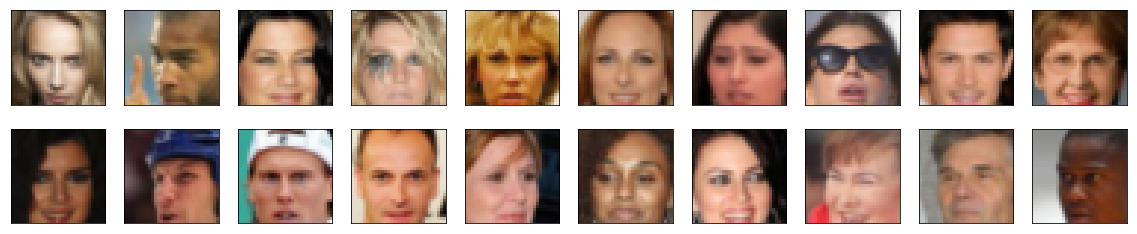

In [5]:
def imshow(img):
    """
    Helper function for image visualization 
    """
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(celeba_train_loader)
images, _ = dataiter.next()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Data pre-processing

Because we are going to use a `tanh` activated function in a generator, the output's pixel values will be in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.). It makes a discriminator's input and the generator's output consistent.

In [2]:
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min_, max_ = feature_range
    x = x * (max_ - min_) + min_
    return x

In [7]:
# check scaled range. It should be close to -1 to 1.
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9843)
Max:  tensor(0.9608)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

This is a convolutional classifier only without any max-pooling layers. To deal with this complex data, a deep network with **batch normalization** is used. Generator's definition comes further.

In [8]:
import torch.nn as nn
import torch.nn.functional as F

# helper conv function
def conv(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=True):
    """
    Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels, 
                           kernel_size, stride, padding, bias=False)
    
    # append conv layer
    layers.append(conv_layer)

    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
     
    # using Sequential container
    return nn.Sequential(*layers)

In [ ]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        self.conv_dim = conv_dim # 32x32 input
        self.conv1 = conv(3, conv_dim, batch_norm=False) # first layer, no batch_norm # 16x16 out
        self.conv2 = conv(conv_dim, conv_dim*2) # 8x8 out
        self.conv3 = conv(conv_dim*2, conv_dim*4) # 4x4 out
        self.conv4 = conv(conv_dim*4, conv_dim*8) # 2x2 out
        self.fc = nn.Linear(conv_dim*8*2*2, 1) # final, fully-connected layer
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        
        # all hidden layers + leaky relu activation
        out = F.leaky_relu(self.conv1(x), 0.2)
        out = F.leaky_relu(self.conv2(out), 0.2)
        out = F.leaky_relu(self.conv3(out), 0.2)
        out = F.leaky_relu(self.conv4(out), 0.2)
        
        out = out.view(-1, self.conv_dim*8*2*2) # flatten
        out = self.fc(out) # final output layer     
        
        return out

## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transposed convolutional layers with normalization applied to the outputs.

In [10]:
def deconv(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=True):
    """Creates a transposed-convolutional layer, with optional batch normalization.
    """
    # sequence of transpose + optional batch norm layers
    layers = []
    transpose_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, 
                                              kernel_size, stride, padding, bias=False)
    # append transpose convolutional layer
    layers.append(transpose_conv_layer)
    
    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

In [ ]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()
        
        self.conv_dim = conv_dim
        
        # first, fully-connected layer
        self.fc = nn.Linear(z_size, conv_dim*8*2*2)

        # transpose conv layers
        self.t_conv1 = deconv(conv_dim*8, conv_dim*4)
        self.t_conv2 = deconv(conv_dim*4, conv_dim*2)
        self.t_conv3 = deconv(conv_dim*2, conv_dim)
        self.t_conv4 = deconv(conv_dim, 3, batch_norm=False)
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        
        # fully-connected + reshape 
        out = self.fc(x)
        out = out.view(-1, self.conv_dim*8, 2, 2) 
        
        # hidden transpose conv layers + relu
        out = F.relu(self.t_conv1(out))
        out = F.relu(self.t_conv2(out))
        out = F.relu(self.t_conv3(out))
        
        # last layer + tanh activation
        out = self.t_conv4(out)
        out = F.tanh(out)
        
        return out

## Initialize the weights of the networks

To help models to converge, the weights of the convolutional and linear layers should be initialized according to the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with a standard deviation of 0.02.

In [4]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    
    classname = m.__class__.__name__
    
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        torch.nn.init.normal_(m.weight.data, mean=0.0, std=0.02)
        if hasattr(m, 'bias') and m.bias is not None:
            torch.nn.init.constant_(m.bias.data, 0.0)

## Build a complete network

Define models' hyperparameters and instantiate the discriminator and generator from the classes defined above.

In [13]:
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G

####  Hyperparameters definition 

In [ ]:
# Define model hyperparams
d_conv_dim = 32
g_conv_dim = 32
z_size = 100

D, G = build_network(d_conv_dim, g_conv_dim, z_size)

### Training on GPU

Train on GPU if is available. Here, a boolean variable `train_on_gpu` is set `True` if GPU is found.

Are moved to GPU, where appropriate:
>* Models
* Model inputs
* Loss function arguments

In [15]:
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Loss calculation for both types of adversarial networks.

### Discriminator Losses

For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`.

### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

Cross entropy loss is used for both networks (but least square errors can  also be just fine). In addition, it is recommended to use smoothing for discriminator's real loss.

In [16]:
def real_loss(D_out, smooth = False):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    
    batch_size = D_out.size(0)
    
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
        
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers for your Discriminator (D) and Generator (G)

According to the article [UNSUPERVISED REPRESENTATION LEARNING WITH DEEP CONVOLUTIONAL GENERATIVE ADVERSARIAL NETWORKS](https://arxiv.org/pdf/1511.06434.pdf): 
> We found the suggested learning rate of 0.001, to be too high, using 0.0002 instead.
Additionally, we found leaving the momentum term β1 at the suggested value of 0.9 resulted in 
training oscillation and instability while reducing it to 0.5 helped stabilize training.

In [34]:
import torch.optim as optim

# params
lr = 0.0002
beta1=0.5
beta2=0.999 # default value

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. Functions `real_loss` and `fake_loss` are used to calculate the discriminator losses.

* First train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function

In [35]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)
            
            if train_on_gpu:
                real_images = real_images.cuda()

            # 1. Train the discriminator on real and fake images
            d_optimizer.zero_grad()
            D_real = D(real_images)
            d_real_loss = real_loss(D_real, smooth=True)
            
            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            # move x to GPU, if available
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            
            # Compute the discriminator losses on fake images            
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)

            # add up loss and perform backprop
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()
        
            # 2. Train the generator with an adversarial loss
            
            g_optimizer.zero_grad()
            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)

            # Compute the discriminator losses on fake images 
            # using flipped labels!
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake) # use real loss to flip labels

            # perform backprop
            g_loss.backward()
            g_optimizer.step()            

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode
        
        # save models
        torch.save(G.state_dict(), 'G_checkpoint.pth')
        torch.save(D.state_dict(), 'D_checkpoint.pth')

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

In [ ]:
from workspace_utils import active_session
n_epochs = 100

with active_session():
    losses = train(D, G, n_epochs=n_epochs)
    
    with open('train_losses.pkl', 'wb') as f:
        pkl.dump(losses, f)

In [37]:
# Load model weights
G_state_dict = torch.load('G_checkpoint.pth')
G.load_state_dict(G_state_dict)

D_state_dict = torch.load('D_checkpoint.pth')
D.load_state_dict(D_state_dict)

with open('train_samples.pkl', 'rb') as f:
        samples = pkl.load(file=f)
        
with open('train_losses.pkl', 'rb') as f:
        losses = pkl.load(file=f)

## Training loss

The training losses for the generator and discriminator

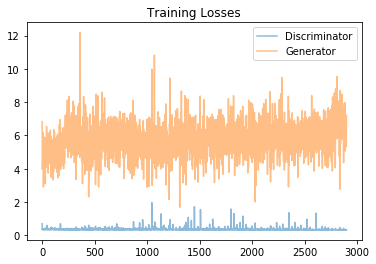

In [39]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

In [40]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [41]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

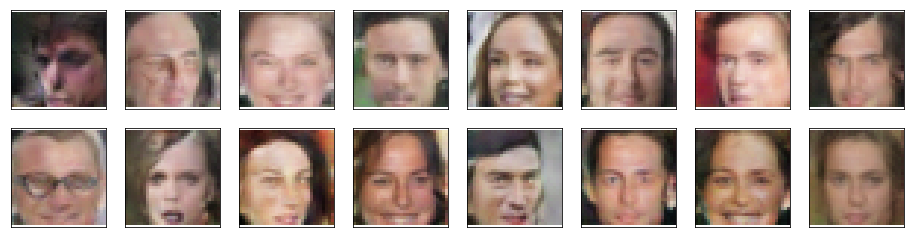

In [30]:
_ = view_samples(-1, samples)

**Results interpretation and further improvements:**

* The dataset is biased because there are only pretty celebrities and mostly white people.
* Model size can be larger. Currently, only four convolutional and transposed convolutional layers are used. For instance, ResNet module can add value and a larger number of convolutional layers, dropouts, etc.
* Image size can be taken as 64*64 instead of 32*32
* Data augmentations like brightness, rotation, etc. could add value
* Regarding optimization, the outputs with different batch sizes look a bit different and if it is large (128 and more) - the quality of generated images is deteriorated. On the other hand, if it is too low, the gradients are volatile.